# Cloudbutton Geospatial: Water Consumption Workflow

---

In [1]:
import sys
sys.path.append('../')

In [105]:
from collections import defaultdict
from cloudbutton_geospatial.io_utils.plot import plot_results
from cloudbutton_geospatial.utils.notebook import date_picker
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from shapely.geometry import Point, MultiPoint, box
from pprint import pprint
import functools
import datetime
import os
import shutil
import math
import numpy as np
import pandas as pd
import lithops
import requests
import rasterio
import json
import random
import re
import utm
import tempfile
import ipyleaflet
import ipywidgets
import concurrent.futures
from IPython.display import Image
import matplotlib.pyplot as plt
from lithops.storage import Storage
from lithops.storage.utils import StorageNoSuchKeyError

## Workflow parameters

Area outside the processed tile that we want to consider for taking SIAM stations into account:

In [3]:
AREA_OF_INFLUENCE = 4000

Lithops Variables:

In [4]:
DATA_BUCKET = 'cloudbutton-geospatial-wc'
COMPUTE_BACKEND = 'localhost'
STORAGE_BACKEND = 'localhost'
STORAGE_PREFIX = 'localhost://'
RUNTIME = 'aitorarjona/cloudbutton-geospatial-wc:01'
RUNTIME_MEMORY = 2048

In [5]:
DTM_ASC_PREFIX = 'DTMs/asc/'
DTM_GEOTIFF_PREFIX = 'DTMs/geotiff/'

Split tile into square chunks (number of tiles = SPLITS^2):

In [6]:
SPLITS = 3

Correlation coefficient between elevation and temperature:

In [7]:
r = -0.0056

Elevation to interpolate temperature:

In [8]:
zdet = 2000

Day of year to calculate solar irradiation:

In [9]:
date = date_picker(default=datetime.date(2022, 5, 15))

DatePicker(value=datetime.date(2022, 5, 15), description='Pick a Date')

In [10]:
DAY_OF_YEAR = date.value.timetuple().tm_yday
DAY_OF_YEAR

135

In [11]:
storage = lithops.storage.Storage(backend=STORAGE_BACKEND)

In [12]:
fexec = lithops.FunctionExecutor(backend=COMPUTE_BACKEND, storage=STORAGE_BACKEND, runtime=RUNTIME, runtime_memory=RUNTIME_MEMORY)

2022-06-02 22:31:02,021 [INFO] lithops.config -- Lithops v2.6.0
2022-06-02 22:31:02,022 [INFO] lithops.storage.backends.localhost.localhost -- Localhost storage client created
2022-06-02 22:31:02,023 [INFO] lithops.localhost.localhost -- Localhost compute client created


## Data preparation

Get meteorological data for selected date (12:00h) and station locations from Catalonia Open Data portal

In [13]:
XEMA_DATA_URL = 'https://analisi.transparenciacatalunya.cat/resource/nzvn-apee.json'
XEMA_META_STATIONS = 'https://analisi.transparenciacatalunya.cat/resource/yqwd-vj5e.json'
XEMA_META_VARS = 'https://analisi.transparenciacatalunya.cat/resource/4fb2-n3yi.json'

def get_meteo_stations():
    if os.path.exists('meta_cache/meteo_stations.csv'):
        print('Getting meteo station from local cache')
        with open('meta_cache/meteo_stations.csv', 'r') as f:
            stations_meta = pd.read_csv(f)
        return stations_meta
    
    print('Fetching meteo station from analisi.transparenciacatalunya.cat...')
    res = requests.get(XEMA_META_STATIONS, params={'NOM_ESTAT': f'Operativa'})
    stations_meta = pd.DataFrame(res.json())
    return stations_meta

def get_meteo_variables():
    if os.path.exists('meta_cache/meteo_variables.csv'):
        print('Getting meteo variables from local cache')
        with open('meta_cache/meteo_variables.csv', 'r') as f:
            vars_meta = pd.read_csv(f)
        return vars_meta
            
    print('Fetching meteo station from analisi.transparenciacatalunya.cat...')
    res = requests.get(XEMA_META_VARS)
    vars_meta = pd.DataFrame(res.json())
    return vars_meta
    
def get_meteo_data(date, stations_meta, vars_meta):
    if os.path.exists(f'meta_cache/meteo-meta-{date.isoformat()}.csv'):
        print(f'Getting meteo data for day {date.isoformat()} from local cache')
        with open(f'meta_cache/meteo-meta-{date.isoformat()}.csv', 'r') as f:
            vars_meta = pd.read_csv(f)
        return vars_meta
    print(f'Fetching meteo data for day {date.isoformat()} from analisi.transparenciacatalunya.cat...')
    res = requests.get(XEMA_DATA_URL, params={'data_lectura': f'{date.isoformat()}T12:00:00.000'})
    xema_day = pd.DataFrame(res.json()).set_index('id')
    
    merged = xema_day.merge(stations_meta, on="codi_estacio").merge(vars_meta, on="codi_variable")
    merged = merged[["codi_estacio", "nom_estacio", "latitud", "longitud", "acronim", "valor_lectura"]]
    
    merged_transposed = (merged.groupby(['codi_estacio', 'nom_estacio', 'latitud', 'longitud'])
                         .apply(lambda group: group[['acronim', 'valor_lectura']].set_index('acronim').T.reset_index(drop=True).rename_axis(None, axis=1))
                         .reset_index().drop(['level_4'], axis=1).set_index('codi_estacio'))
    x_y_coords = pd.DataFrame(merged_transposed.apply(lambda row: utm.from_latlon(float(row['latitud']), float(row['longitud'])), axis=1).to_list(), 
                              columns=['X', 'Y', 'zone_num', 'zone_letter'])
    x_y_coords = x_y_coords.drop(['zone_num', 'zone_letter'], axis=1)
    meteo_data = pd.concat([merged_transposed.reset_index(), x_y_coords.reset_index()], axis=1).drop('index', axis=1).set_index('codi_estacio')
    return meteo_data

In [14]:
# meteo_data.apply(lambda row: print(type(row['latitud'])), axis=1)

In [15]:
meteo_stations = get_meteo_stations()
meteo_vars = get_meteo_variables()
meteo_data = get_meteo_data(date.value, meteo_stations, meteo_vars)

Getting meteo station from local cache
Getting meteo variables from local cache
Getting meteo data for day 2022-05-15 from local cache


In [16]:
meteo_data.sample(10)

,codi_estacio,nom_estacio,latitud,longitud,RS,HRx,T,HR,PPT,Tx,...,DV2,VVx2,DVVx2,RN,VV6,DV6,VVx6,DVVx6,X,Y
6,CE,els Hostalets de Pierola,41.53109,1.80813,945.0,24.0,28.5,22.0,0.0,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400569.938024,4.598402e+06
58,UH,el Montmell,41.34171,1.48769,977.0,30.0,27.9,29.0,0.0,28.6,...,NaN,NaN,NaN,NaN,3.1,172.0,7.8,149.0,373469.650719,4.577794e+06
49,U4,Castellnou de Bages,41.83094,1.84699,1011.0,30.0,27.9,28.0,0.0,28.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,404257.392259,4.631649e+06
69,UW,els Alfacs,40.62725,0.65922,961.0,74.0,23.6,70.0,0.0,23.9,...,163.0,3.1,139.0,500.0,NaN,NaN,NaN,NaN,302023.458241,4.500014e+06
63,UN,Cassà de la Selva,41.87449,2.92694,927.0,37.0,26.9,35.0,0.0,27.7,...,193.0,7.9,222.0,NaN,NaN,NaN,NaN,NaN,493937.469003,4.635844e+06
16,CY,Muntanyola,41.87813,2.17873,926.0,32.0,25.1,31.0,0.0,25.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,431854.488644,4.636571e+06
76,Z8,el Port del Comte (2.316 m),42.18254,1.52407,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,378115.601242,4.671098e+06
59,UI,Gisclareny,42.26477,1.76218,NaN,41.0,22.2,37.0,0.0,22.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,397911.980584,4.679916e+06
36,DQ,Vila-rodona,41.30728,1.36259,955.0,30.0,26.6,29.0,0.0,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,362930.409195,4.574162e+06
3,C9,Mas de Barberans,40.71825,0.39988,953.0,36.0,24.8,34.0,0.0,25.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280386.027555,4.510733e+06


In [17]:
meteo_vars[['acronim', 'nom_variable', 'unitat']]

,acronim,nom_variable,unitat
0,PPTx1min,Precipitació màxima en 1 minut,mm
1,HRx,Humitat relativa màxima,%
2,VV10,Velocitat del vent a 10 m (esc.),m/s
3,DV10,Direcció de vent 10 m (m. 1),°
4,T,Temperatura,°C
5,HR,Humitat relativa,%
6,P,Pressió atmosfèrica,hPa
7,PPT,Precipitació,mm
8,RS,Irradiància solar global,W/m²
9,GNEU,Gruix de neu a terra,mm


Store metadata to local cache

In [18]:
if not os.path.exists('meta_cache/meteo_stations.csv'):
    with open('meta_cache/meteo_stations.csv', 'w') as f:
        meteo_stations.to_csv(f, index=False)

if not os.path.exists('meta_cache/meteo_variables.csv'):
    with open('meta_cache/meteo_variables.csv', 'w') as f:
        meteo_vars.to_csv(f, index=False)
        
if not os.path.exists(f'meta_cache/meteo-meta-{date.value.isoformat()}.csv'):
    with open(f'meta_cache/meteo-meta-{date.value.isoformat()}.csv', 'w') as f:
        meteo_data.to_csv(f, index=True)

Upload metadata to Cloud Object Storage

In [19]:
meteo_key = f'meteo-meta-{date.value.isoformat()}.csv'
try:
    storage.head_object(bucket=DATA_BUCKET, key=meteo_key)
except StorageNoSuchKeyError:
    print('Uploading meteo data to Object Storage...')
    body = meteo_data.to_csv().encode('utf-8')
    storage.put_object(bucket=DATA_BUCKET, key=meteo_key, body=body)

Uploading meteo data to Object Storage...


### Digital Terrain Models

Download DTM files for free from http://centrodedescargas.cnig.es/CentroDescargas/buscadorCatalogo.do?codFamilia=MDT05# and put them in `inpit_DTMs` folder.

In [20]:
dtm_asc_keys = storage.list_keys(bucket=DATA_BUCKET, prefix=DTM_ASC_PREFIX)
dtm_asc_keys

[]

Upload tiles from local input folder:

In [21]:
local_dtm_input = 'input_DTMs'
local_dtms = [os.path.join(local_dtm_input, dtm) for dtm in os.listdir(local_dtm_input) if dtm.endswith('.asc')]

def upload_file(file_path):
    key = os.path.join(DTM_ASC_PREFIX, os.path.basename(file_path))
    if key in dtm_asc_keys:
        print(f'Tile {key} already in storage')
        return key
    with open(file_path, 'rb') as f:
        print(f'Uploading {key}...')
        storage.put_object(bucket=DATA_BUCKET, key=key, body=f)
    return key

with concurrent.futures.ThreadPoolExecutor(max_workers=16) as pool:
    result = list(pool.map(upload_file, local_dtms))
    # list(result)

Uploading DTMs/asc/PNOA_MDT05_ETRS89_HU31_0359_LID.asc...


In [22]:
def asc_to_geotiff(obj, storage):
    asc_file_name = os.path.basename(obj.key)
    tile_id, _ = os.path.splitext(asc_file_name)
    out_path = os.path.join(tempfile.gettempdir(), tile_id + '.tiff')
    out_key = os.path.join(DTM_GEOTIFF_PREFIX, tile_id + '.tiff')
    
    try:
        out_obj = storage.head_object(bucket=DATA_BUCKET, key=out_key)
    except StorageNoSuchKeyError:
        out_obj = None
    
    if out_obj:
        print(f'GeoTIFF {tile_id} already exists, skipping...')
        return out_key
    
    print(f'Converting {tile_id} to GeoTIFF...')
    with rasterio.open(obj.data_stream, 'r') as src:
        profile = src.profile
        # Cloud optimized GeoTiff parameters
        profile.update(driver='GTiff')
        profile.update(blockxsize=256)
        profile.update(blockysize=256)
        profile.update(tiled=True)
        profile.update(compress='deflate')
        profile.update(interleave='band')
        with rasterio.open(out_path, 'w', **profile) as dest:
            dest.write(src.read())
    
    with open(out_path, 'rb') as f:
        storage.put_object(bucket=DATA_BUCKET, key=out_key, body=f)
    
    return out_key

In [24]:
fs = fexec.map(asc_to_geotiff, os.path.join(STORAGE_PREFIX, DATA_BUCKET, DTM_ASC_PREFIX))

2022-06-02 22:34:28,996 [INFO] lithops.invokers -- ExecutorID d90394-0 | JobID M001 - Selected Runtime: aitorarjona/cloudbutton-geospatial-wc:01 
2022-06-02 22:34:29,000 [INFO] lithops.invokers -- Runtime aitorarjona/cloudbutton-geospatial-wc:01 is not yet deployed
2022-06-02 22:34:29,001 [INFO] lithops.localhost.localhost -- Extracting preinstalled Python modules from aitorarjona/cloudbutton-geospatial-wc:01
2022-06-02 22:34:30,189 [INFO] lithops.invokers -- ExecutorID d90394-0 | JobID M001 - Starting function invocation: asc_to_geotiff() - Total: 1 activations
2022-06-02 22:34:30,191 [INFO] lithops.invokers -- ExecutorID d90394-0 | JobID M001 - View execution logs at /tmp/lithops/logs/d90394-0-M001.log


In [25]:
_, _ = fexec.wait(fs=fs)

2022-06-02 22:34:33,774 [INFO] lithops.wait -- ExecutorID d90394-0 - Waiting for 100% of 1 function activations to complete


    0%|          | 0/1  

In [26]:
dtm_geotiff_keys = storage.list_keys(bucket=DATA_BUCKET, prefix=DTM_GEOTIFF_PREFIX)
dtm_geotiff_keys

['DTMs/geotiff/PNOA_MDT05_ETRS89_HU31_0359_LID.tiff']

In [27]:
tile_ids = [os.path.splitext(os.path.basename(dtm))[0] for dtm in dtm_geotiff_keys]
tile_ids

['PNOA_MDT05_ETRS89_HU31_0359_LID']

In [115]:
m = ipyleaflet.Map(center=(41.714557, 1.734188), zoom=8)

for name, lat, lon in meteo_data[['nom_estacio', 'latitud', 'longitud']].values:
    message = ipywidgets.HTML(value=name)
    marker = ipyleaflet.Marker(location=(lat, lon), draggable=True, title=name)
    marker.popup = message
    m.add_layer(marker)

m.layout.height="600px"

m

Map(center=[41.714557, 1.734188], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

## Serverless computation

Split data tiles in subtiles for increased parallelism:

In [28]:
def data_chunker(obj, n_splits, block_x, block_y, storage):
    tile_key = os.path.basename(obj.key)
    tile_id, _ = os.path.splitext(tile_key)
    
    with rasterio.open(obj.data_stream) as src:
        transform = src.transform
        
        # Compute working window
        step_w = src.width / n_splits
        step_h = src.height / n_splits
        
        offset_h = round(step_h * block_x)
        offset_w = round(step_w * block_y)
        
        profile = src.profile
        
        width = math.ceil(step_w * (block_y + 1) - offset_w)
        height = math.ceil(step_h * (block_x + 1) - offset_h)
        
        profile.update(width=width)
        profile.update(height=height)
        
        window = Window(offset_w,offset_h, width, height)
        
        chunk_file = os.path.join(tempfile.gettempdir(), tile_id + str(block_x) + '_' + str(block_y) + '.tif')
        with rasterio.open(chunk_file, 'w', **profile) as dest:
            dest.write(src.read(window=window))
    
    with open(chunk_file, 'rb') as f:
        co = storage.put_cloudobject(body=f, bucket=DATA_BUCKET)
    
    return (tile_key, block_x, block_y, co)

In [29]:
iterdata = [(os.path.join(STORAGE_PREFIX, DATA_BUCKET, tile), SPLITS, i, j) for i in range(SPLITS) for j in range(SPLITS) for tile in dtm_geotiff_keys]
iterdata

[('localhost://cloudbutton-geospatial-wc/DTMs/geotiff/PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  3,
  0,
  0),
 ('localhost://cloudbutton-geospatial-wc/DTMs/geotiff/PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  3,
  0,
  1),
 ('localhost://cloudbutton-geospatial-wc/DTMs/geotiff/PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  3,
  0,
  2),
 ('localhost://cloudbutton-geospatial-wc/DTMs/geotiff/PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  3,
  1,
  0),
 ('localhost://cloudbutton-geospatial-wc/DTMs/geotiff/PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  3,
  1,
  1),
 ('localhost://cloudbutton-geospatial-wc/DTMs/geotiff/PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  3,
  1,
  2),
 ('localhost://cloudbutton-geospatial-wc/DTMs/geotiff/PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  3,
  2,
  0),
 ('localhost://cloudbutton-geospatial-wc/DTMs/geotiff/PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  3,
  2,
  1),
 ('localhost://cloudbutton-geospatial-wc/DTMs/geotiff/PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  3,
  2,
  2)]

In [30]:
chunker_fs = fexec.map(data_chunker, iterdata)

2022-06-02 22:47:51,335 [INFO] lithops.invokers -- ExecutorID d90394-0 | JobID M002 - Selected Runtime: aitorarjona/cloudbutton-geospatial-wc:01 
2022-06-02 22:47:51,343 [INFO] lithops.invokers -- ExecutorID d90394-0 | JobID M002 - Starting function invocation: data_chunker() - Total: 9 activations
2022-06-02 22:47:51,344 [INFO] lithops.invokers -- ExecutorID d90394-0 | JobID M002 - View execution logs at /tmp/lithops/logs/d90394-0-M002.log


In [31]:
chunks = fexec.get_result(fs=chunker_fs)

2022-06-02 22:47:52,538 [INFO] lithops.wait -- ExecutorID d90394-0 - Getting results from 9 function activations


    0%|          | 0/9  

2022-06-02 22:47:55,592 [INFO] lithops.executors -- ExecutorID d90394-0 - Cleaning temporary data


In [32]:
chunks

[('PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  0,
  0,
  <lithops.storage.utils.CloudObject at 0x7f878bfb1dc0>),
 ('PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  0,
  1,
  <lithops.storage.utils.CloudObject at 0x7f878bfb1a60>),
 ('PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  0,
  2,
  <lithops.storage.utils.CloudObject at 0x7f878bfb1c10>),
 ('PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  1,
  0,
  <lithops.storage.utils.CloudObject at 0x7f878bfb1c40>),
 ('PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  1,
  1,
  <lithops.storage.utils.CloudObject at 0x7f878bfb1a00>),
 ('PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  1,
  2,
  <lithops.storage.utils.CloudObject at 0x7f878bfb1880>),
 ('PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  2,
  0,
  <lithops.storage.utils.CloudObject at 0x7f878bfb1940>),
 ('PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  2,
  1,
  <lithops.storage.utils.CloudObject at 0x7f878bfb1bb0>),
 ('PNOA_MDT05_ETRS89_HU31_0359_LID.tiff',
  2,
  2,
  <lithops.storage.utils.CloudObject at 0x7f87909ba7c0>)]

Compute solar irradiation given a day of year using GRASS libraries:

In [33]:
def compute_solar_irradiation(inputFile, outputFile, crs='32630'):
    # Define grass working set
    GRASS_GISDB = 'grassdata'
    GRASS_LOCATION = 'GEOPROCESSING'
    GRASS_MAPSET = 'PERMANENT'
    GRASS_ELEVATIONS_FILENAME = 'ELEVATIONS'

    os.environ['GRASSBIN'] = 'grass76'
    from grass_session import Session
    import grass.script as gscript
    from grass.pygrass.modules.shortcuts import general
    from grass.pygrass.modules.shortcuts import raster

    os.environ.update(dict(GRASS_COMPRESS_NULLS='1'))
    
    # Clean previously processed data
    if os.path.isdir(GRASS_GISDB):
        shutil.rmtree(GRASS_GISDB)
    
    with Session(gisdb=GRASS_GISDB, location=GRASS_LOCATION, mapset=GRASS_MAPSET, create_opts='EPSG:32630') as ses:
        # Set project projection to match elevation raster projection
        general.proj(epsg=crs, flags='c') 
    
        # Load raster file into working directory
        raster.import_(input=inputFile, output=GRASS_ELEVATIONS_FILENAME, flags='o')    
        
        # Set project region to match raster region
        general.region(raster=GRASS_ELEVATIONS_FILENAME, flags='s')    
        # Calculate solar irradiation
        gscript.run_command('r.slope.aspect', elevation=GRASS_ELEVATIONS_FILENAME,
                            slope='slope', aspect='aspect')
        gscript.run_command('r.sun', elevation=GRASS_ELEVATIONS_FILENAME,
                            slope='slope', aspect='aspect', beam_rad='beam',
                            step=1, day=DAY_OF_YEAR)
        
        # Get extraterrestrial irradiation from history metadata
        regex = re.compile(r'\d+\.\d+')
        output = gscript.read_command("r.info", flags="h", map=["beam"])
        splits = str(output).split('\n')
        line = next(filter(lambda line: 'Extraterrestrial' in line, splits))
        extraterrestrial_irradiance = float(regex.search(line)[0])
        
        # Export generated results into a GeoTiff file
        if os.path.isfile(outputFile):
            os.remove(outputFile)

        raster.out_gdal(input='beam', output=outputFile)
        
        return extraterrestrial_irradiance

Get stations contained in the area of interest:

In [53]:
def filter_stations(bounds, meteo_data):
    total_points = MultiPoint([Point(x,y) for x, y in meteo_data[['X', 'Y']].to_numpy()])
    intersection = bounds.buffer(AREA_OF_INFLUENCE).intersection(total_points)
    
    return meteo_data[[intersection.contains(point) for point in total_points]]

Inverse Distance Weighting interpolation:

In [54]:
def compute_basic_interpolation(shape, stations, field_value, offset = (0,0)):
    station_pixels = [[pixel[0], pixel[1]] for pixel in stations['pixel'].to_numpy()]
    
    # Get an array where each position represents pixel coordinates
    tile_pixels = np.indices(shape).transpose(1,2,0).reshape(shape[0]*shape[1], 2) + offset
    dist = distance_matrix(station_pixels, tile_pixels)
    weights = np.where(dist == 0, np.finfo('float32').max, 1.0 / dist )
    weights /=  weights.sum(axis=0)
    
    return np.dot(weights.T, stations[field_value].to_numpy()).reshape(shape).astype('float32')

Interpolate temperatures from a subset of the tile:

In [55]:
def radiation_interpolation(tile_key, block_x, block_y, chunk_cloudobject, storage):
    tile_id, _ = os.path.splitext(tile_key)
    
    # Write tile chunk to file
    chunk_file = os.path.join(tempfile.gettempdir(), tile_id + str(block_x) + '_' + str(block_y) + '.tif')
    with open(chunk_file, 'wb') as f:
        body = storage.get_cloudobject(chunk_cloudobject)
        f.write(body)
    
    with rasterio.open(chunk_file, 'r') as chunk_src:
        profile = chunk_src.profile
        
    extr_chunk_file = os.path.join(tempfile.gettempdir(), tile_id + '_extr_' + str(block_x) + '_' + str(block_y) + '.tif')
    rad_chunk_file = os.path.join(tempfile.gettempdir(), tile_id + '_rad_' + str(block_x) + '_' + str(block_y) + '.tif')
    
    # Compute solar irradiation from inputFile, creates radiation raster at outputFile
    extraterrestrial_irradiation = compute_solar_irradiation(inputFile=chunk_file, outputFile=rad_chunk_file)
        
    # Create and store a raster with extraterrestrial irradiation
    with rasterio.open(extr_chunk_file, 'w', **profile) as dest:
        data = np.full((profile['height'], profile['width']), extraterrestrial_irradiation, dtype='float32')
        dest.write(data, 1)
    
    with open(extr_chunk_file, 'rb') as f:
        extr_co = storage.put_cloudobject(body=f, bucket=DATA_BUCKET)
    
    with open(rad_chunk_file, 'rb') as f:
        rad_co = storage.put_cloudobject(body=f, bucket=DATA_BUCKET)
    
    return [(tile_key, 'extr', block_x, block_y, extr_co), (tile_key, 'rad', block_x, block_y, rad_co)]

In [80]:
def map_interpolation(tile_key, block_x, block_y, chunk_cloudobject, data_field, storage):
    tile_id, _ = os.path.splitext(tile_key)
    
    # Get meteo data CSV
    meteo_data_stream = storage.get_object(DATA_BUCKET, meteo_key, stream=True)
    meteo_data = pd.read_csv(meteo_data_stream)
    
    # Write tile chunk to file
    chunk_file = os.path.join(tempfile.gettempdir(), tile_id + str(block_x) + '_' + str(block_y) + '.tif')
    with open(chunk_file, 'wb') as f:
        body = storage.get_cloudobject(chunk_cloudobject)
        f.write(body)
    
    with rasterio.open(chunk_file, 'r') as chunk_src:
        profile = chunk_src.profile
        transform = chunk_src.transform
        
        # bounding_rect = box(chunk_src.bounds.left, chunk_src.bounds.top, chunk_src.bounds.right, chunk_src.bounds.bottom)
        # filtered = pd.DataFrame(filter_stations(bounding_rect, meteo_data))
        filtered = meteo_data
        filtered = meteo_data.apply(lambda station: rasterio.transform.rowcol(transform, station['X'], station['Y']), axis=1)
        
        # Interpolate variables from meteo station data, generate raster with result
        if data_field == 'temp':
            dest_chunk_file = os.path.join(tempfile.gettempdir(), tile_id + '_temp_' + str(block_x) + '_' + str(block_y) + '.tif')
            with rasterio.open(dest_chunk_file, 'w', **profile) as chunk_dest:
                elevations = chunk_src.read(1)  # Get elevations content
                interpolation = compute_basic_interpolation(elevations.shape, meteo_data, 'tdet', (offset_h, offset_w))
                interpolation += r * (elevations - zdet)
                chunk_dest.write(np.where(elevations == src.nodata, np.nan, interpolation), 1)
        elif data_field == 'humi':
            dest_chunk_file = os.path.join(tempfile.gettempdir(), tile_id + '_humi_' + str(block_x) + '_' + str(block_y) + '.tif')
            interpolation = compute_basic_interpolation((height, width), meteo_data, 'hr', (offset_h, offset_w))
            chunk_dest.write(interpolation, 1)
        elif data_field == 'wind':
            dest_chunk_file = os.path.join(tempfile.gettempdir(), tile_id + '_wind_' + str(block_x) + '_' + str(block_y) + '.tif')
            interpolation = compute_basic_interpolation((height, width), meteo_data, 'v', (offset_h, offset_w))
            chunk_dest.write(interpolation, 1)
        else:
            raise Exception(f'Unknown data field "{data_field}"')

    # Upload results to storage as Cloudobject
    with open(dest_chunk_file, 'rb') as f:
        co = storage.put_cloudobject(body=f, bucket=DATA_BUCKET)
    
    return [(tile_key, data_field, block_x, block_y, co)]

Lithops serverless computation:

In [81]:
# fs1 = fexec.map(radiation_interpolation, chunks)
fs2 = fexec.map(map_interpolation, chunks, extra_args=('temp',))
# fs3 = fexec.map(map_interpolation, iterdata, extra_args=(SPLITS, 'humi'))
# fs4 = fexec.map(map_interpolation, iterdata, extra_args=(SPLITS, 'wind'))

2022-06-02 23:17:21,093 [INFO] lithops.invokers -- ExecutorID d90394-0 | JobID M013 - Selected Runtime: aitorarjona/cloudbutton-geospatial-wc:01 
2022-06-02 23:17:21,106 [INFO] lithops.invokers -- ExecutorID d90394-0 | JobID M013 - Starting function invocation: map_interpolation() - Total: 9 activations
2022-06-02 23:17:21,107 [INFO] lithops.invokers -- ExecutorID d90394-0 | JobID M013 - View execution logs at /tmp/lithops/logs/d90394-0-M013.log


In [82]:
res2 = fexec.get_result(fs=fs2)

2022-06-02 23:17:21,263 [INFO] lithops.wait -- ExecutorID d90394-0 - Getting results from 9 function activations


    0%|          | 0/9  

2022-06-02 23:17:23,331 [INFO] lithops.executors -- ExecutorID d90394-0 - Cleaning temporary data


NameError: name 'offset_h' is not defined

In [117]:
import geopandas

gdf = geopandas.GeoDataFrame(meteo_data, geometry=geopandas.points_from_xy(meteo_data['longitud'], meteo_data['latitud']), crs="EPSG:4326")

In [118]:
gdf

,codi_estacio,nom_estacio,latitud,longitud,RS,HRx,T,HR,PPT,Tx,...,VVx2,DVVx2,RN,VV6,DV6,VVx6,DVVx6,X,Y,geometry
0,C6,Castellnou de Seana,41.65660,0.95172,942.0,30.0,29.8,28.0,0.0,30.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,329453.051334,4.613677e+06,POINT (0.95172 41.65660)
1,C7,Tàrrega,41.66695,1.16234,963.0,24.0,29.0,23.0,0.0,29.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,347015.268486,4.614430e+06,POINT (1.16234 41.66695)
2,C8,Cervera,41.67555,1.29609,957.0,28.0,26.9,27.0,0.0,27.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,358169.209304,4.615156e+06,POINT (1.29609 41.67555)
3,C9,Mas de Barberans,40.71825,0.39988,953.0,36.0,24.8,34.0,0.0,25.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280386.027555,4.510733e+06,POINT (0.39988 40.71825)
4,CC,Orís,42.07398,2.20862,957.0,29.0,27.8,27.0,0.0,28.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,434535.543626,4.658293e+06,POINT (2.20862 42.07398)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,WA,Oliola,41.87694,1.15410,NaN,NaN,NaN,24.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,346829.830334,4.637760e+06,POINT (1.15410 41.87694)
73,WV,Guardiola de Berguedà,42.23414,1.87485,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,407159.541620,4.676386e+06,POINT (1.87485 42.23414)
74,X5,PN dels Ports,40.79705,0.31822,NaN,NaN,20.6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273755.565351,4.519689e+06,POINT (0.31822 40.79705)
75,YC,la Pobla de Segur,42.24388,0.96802,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,332356.908891,4.678853e+06,POINT (0.96802 42.24388)


In [120]:
geo_df_3301 = gdf.dropna(subset=['T']).to_crs(epsg=3301)
geo_df_3301['x'] = geo_df_3301['geometry'].apply(lambda p: p.x)
geo_df_3301['y'] = geo_df_3301['geometry'].apply(lambda p: p.y)
display(geo_df_3301.head(5))

,codi_estacio,nom_estacio,latitud,longitud,RS,HRx,T,HR,PPT,Tx,...,RN,VV6,DV6,VVx6,DVVx6,X,Y,geometry,x,y
0,C6,Castellnou de Seana,41.65660,0.95172,942.0,30.0,29.8,28.0,0.0,30.6,...,NaN,NaN,NaN,NaN,NaN,329453.051334,4.613677e+06,POINT (-1457203.006 4925124.611),-1.457203e+06,4.925125e+06
1,C7,Tàrrega,41.66695,1.16234,963.0,24.0,29.0,23.0,0.0,29.6,...,NaN,NaN,NaN,NaN,NaN,347015.268486,4.614430e+06,POINT (-1439618.403 4920132.726),-1.439618e+06,4.920133e+06
2,C8,Cervera,41.67555,1.29609,957.0,28.0,26.9,27.0,0.0,27.3,...,NaN,NaN,NaN,NaN,NaN,358169.209304,4.615156e+06,POINT (-1428367.654 4917212.875),-1.428368e+06,4.917213e+06
3,C9,Mas de Barberans,40.71825,0.39988,953.0,36.0,24.8,34.0,0.0,25.5,...,NaN,NaN,NaN,NaN,NaN,280386.027555,4.510733e+06,POINT (-1539560.333 4839474.103),-1.539560e+06,4.839474e+06
4,CC,Orís,42.07398,2.20862,957.0,29.0,27.8,27.0,0.0,28.4,...,NaN,NaN,NaN,NaN,NaN,434535.543626,4.658293e+06,POINT (-1338994.290 4935054.450),-1.338994e+06,4.935054e+06


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 1.5384989671850453e-05
Nugget: 4.515840408012788 



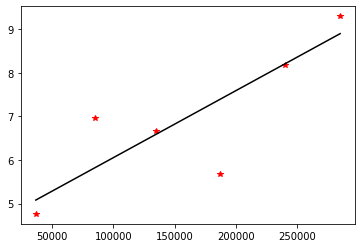

Calculating statistics on variogram model fit...


In [136]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

OK = OrdinaryKriging(geo_df_3301['x'].astype(float).values,
                     geo_df_3301['y'].astype(float).values,
                     geo_df_3301['T'].values,
                     variogram_model='linear',
                     verbose=True,
                     enable_plotting=True)

In [137]:
all_dist_m = geo_df_3301['x'].max() - geo_df_3301['x'].min()
dist_km_x = all_dist_m / 1000
display(dist_km_x)

all_dist_m_y = geo_df_3301['y'].max() - geo_df_3301['y'].min()
dist_km_y = all_dist_m_y / 1000
display(dist_km_y)

297.4693349766857

193.38601648181864

In [138]:
nx=int(dist_km_x)
ny=int(dist_km_y)

In [139]:
x_spacing = np.linspace(geo_df_3301['x'].min(), geo_df_3301['x'].max(), nx)
y_spacing = np.linspace(geo_df_3301['y'].min(), geo_df_3301['y'].max(), ny)

In [140]:
z, ss = OK.execute('grid', x_spacing, y_spacing)

Executing Ordinary Kriging...



In [141]:
display(z.shape)
display(ss.shape)

(193, 297)

(193, 297)

In [142]:
x=geo_df_3301['x'].astype(float).values
y=geo_df_3301['y'].astype(float).values
# z=geo_df_3301['T'].values

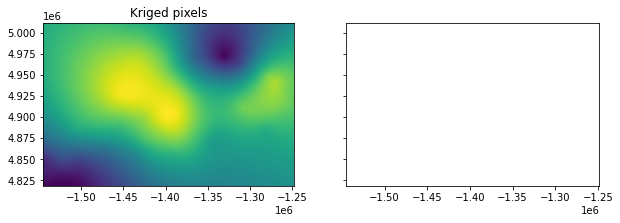

In [143]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))

ax1.imshow(np.flipud(z), extent=(x.min(), x.max(), y.min(), y.max()))
ax1.set_title('Kriged pixels')

# ax2.contourf(np.linspace(x.min(), x.max(), nx), np.linspace(y.min(), y.max(), ny), z)
# ax2.set_title('Kriged interpolation contours')


plt.show()

In [ ]:
res1

In [ ]:
fs_flat = [fs for sublist in [fs1, fs2, fs3, fs4] for fs in sublist]

In [ ]:
res = fexec.get_result(fs=fs_flat)

---

### KPIs (Interpolation)

[Skip KPI section](#(End-of-KPI-section---Interpolation))

In [ ]:
fexec.plot(dst="plots/interpolation")

In [ ]:
Image(filename="plots/interpolation_histogram.png")

In [ ]:
Image(filename="plots/interpolation_timeline.png")

#### Data size 

List of .tif files being processed:

In [ ]:
mdts_gtiff

Total size accounting that files were repeatedly processed:

In [ ]:
data_size = sum(obj["Size"] for obj in cloud_storage.list_objects(BUCKET) if obj["Key"] in mdts_gtiff)
data_size *= 4  # Each file was processed 4 times

print(f"Data size: {data_size / 1024**2} MiB")

#### KPI: Cost

In [ ]:
fexec.job_summary()

In [ ]:
pd.read_csv(fexec.log_path)

In [ ]:
cost_interpolation = get_process_cost(fexec)
print(f"The experiment cost ${cost_interpolation:.4f}.")

#### KPI: Throughput

In [ ]:
tstamps = set()
for future in fexec.futures:
    for key in future.stats.keys():
        if key.endswith("tstamp"):
            tstamps.add(future.stats[key])
            
duration = max(tstamps) - min(tstamps)
print("Duration: " + str(duration) + " seconds")

In [ ]:
throughput_interpolation = data_size / duration  # Bytes/second

In [ ]:
print(f"Throughput: {throughput_interpolation / 1024**2} MiB/s")

#### KPI: Speedup

In this section we compare the execution speed of a sample process performed in last section, using different amounts of parallel workers, in order to test the scalability of the process.

In [ ]:
parallel_workers = [12, 24, 48, 72]
experiment_duration = dict.fromkeys(parallel_workers)

Perform experiment several times and save duration:

In [ ]:
for option in parallel_workers:
    fexec = lithops.FunctionExecutor(
        backend=COMPUTE_BACKEND, 
        storage=STORAGE_BACKEND,
        runtime=RUNTIME,
        workers=option, # Tells lithops to work w/only this number of concurrent workers
        log_level="DEBUG"
    )
    fexec.map(
        map_interpolation, iterdata, extra_args=(SPLITS,'temp'), runtime_memory=2048
    )
    fexec.get_result()
    
    tstamps = set()
    for future in fexec.futures:
        for key in future.stats.keys():
            if key.endswith("tstamp"):
                tstamps.add(future.stats[key])
    duration = max(tstamps) - min(tstamps)
    experiment_duration[option] = duration

In [ ]:
experiment_duration

##### Visualization of per-worker performance relative to first experiment

The following plot represents two lines:
- **Ideal speedup**: theoretical best speedup - scenario where a 2x increment in workers results in 1/2 execution time, a 4x increment in workers results in a 1/4 execution time, etc.
- **Lithops speedup**: actual speedup that results from the experiment

In [ ]:
duration = list(experiment_duration.values())
theoretical_best_speedup = [(1 - parallel_workers[0] / parallel_workers[i]) * 100 for i in range(0, len(parallel_workers))]
actual_speedup = [(1 - duration[i] / duration[0]) * 100 for i in range(0, len(duration))]

plt.plot(
    parallel_workers,
    theoretical_best_speedup
)
plt.plot(
    parallel_workers,
    actual_speedup
)
plt.xlabel("Number of workers")
plt.ylabel("% time reduced, relative to first experiment")
plt.legend(["Ideal speedup", "Lithops speedup (this experiment)"])

Clean stats:

In [ ]:
fexec.futures = []

###### (End of KPI section - Interpolation)

---

Join split subsets into a tile:

In [ ]:
def gather_blocks(tile, splits, data_field, storage):

    from rasterio.windows import Window
    
    # Get width and height from original tile
    with rasterio.open(storage.get_object(bucket=BUCKET, key=f'MDT/{tile}.tif', stream=True)) as og:
        height = og.profile['height']
        width = og.profile['width']
    
    chunk_tiles = storage.list_keys(bucket=BUCKET, prefix=f'tmp/{data_field}/{tile}/chunk')
        
    # Open first object to obtain profile metadata
    with rasterio.open(storage.get_object(bucket=BUCKET, key=chunk_tiles[0], stream=True)) as src:
        profile = src.profile
        profile.update(width=width)
        profile.update(height=height)

    # Iterate each object and print its block into the destination file
    with rasterio.open("output", "w", **profile) as dest: 
        for chunk in chunk_tiles:
            j, i = os.path.splitext(os.path.basename(chunk))[0].rsplit('_')[1].split('-')
            j, i = int(j), int(i)
            with rasterio.open(storage.get_object(bucket=BUCKET, key=chunk, stream=True)) as src:
                step_w = math.floor(width / splits)
                step_h = math.floor(height / splits)
                curr_window = Window(round(step_w * i), round(step_h * j), src.width, src.height)
                content = src.read(1)
                dest.write(content, 1, window=curr_window)
            # storage.delete_object(bucket=BUCKET, key=chunk)
    
    output_key = os.path.join('tmp', data_field, tile, '_'.join([tile, data_field.upper()+'.tif']))
    with open('output', 'rb') as out_file:
        storage.put_object(bucket=BUCKET, key=output_key, body=out_file)  
    
    return output_key

Combine previous split subsets:

In [ ]:
fexec.map(gather_blocks, tiles, extra_args=(SPLITS, 'extrad'), runtime_memory=2048)

fexec.map(gather_blocks, tiles, extra_args=(SPLITS, 'humi'), runtime_memory=2048)

fexec.map(gather_blocks, tiles, extra_args=(SPLITS, 'rad'), runtime_memory=2048)

fexec.map(gather_blocks, tiles, extra_args=(SPLITS, 'temp'), runtime_memory=2048)

fexec.map(gather_blocks, tiles, extra_args=(SPLITS, 'wind'), runtime_memory=2048)

out_combined = fexec.get_result()

### KPIs (Gather blocks)

[Skip KPI section](#(End-of-KPI-section---Gather-blocks))

In [ ]:
fexec.plot(dst="plots/gather_blocks")

In [ ]:
Image(filename="plots/gather_blocks_histogram.png")

In [ ]:
Image(filename="plots/gather_blocks_timeline.png")

#### Data size

In [ ]:
mdts_gtiff

In [ ]:
data_size = sum(obj["Size"] for obj in cloud_storage.list_objects(BUCKET) if obj["Key"] in mdts_gtiff)
data_size *= 4  # Each file was processed 4 times

print(f"Data size: {data_size / 1024**2} MiB")

#### KPI: Cost

In [ ]:
fexec.job_summary()

In [ ]:
pd.read_csv(fexec.log_path)

In [ ]:
cost_gather_blocks = get_process_cost(fexec)
print(f"The experiment cost ${cost_gather_blocks:.4f}.")

#### KPI: Throughput

In [ ]:
tstamps = set()
for future in fexec.futures:
    for key in future.stats.keys():
        if key.endswith("tstamp"):
            tstamps.add(future.stats[key])
            
duration = max(tstamps) - min(tstamps)
print("Duration: " + str(duration) + " seconds")

In [ ]:
throughput_gather_blocks = data_size / duration  # Bytes/second

In [ ]:
print(f"Throughput: {throughput_gather_blocks / 1024**2} MiB/s")

Clean stats:

In [ ]:
fexec.futures = []

###### (End of KPI section - Gather blocks)

---

## Computation of potential evaporation

In [ ]:
def compute_crop_evapotranspiration(temperatures,
                                    humidities,
                                    wind_speeds,
                                    external_radiations,
                                    global_radiations,
                                    KCs):
    gamma = 0.665*101.3/1000
    eSat = 0.6108 * np.exp((17.27*temperatures)/(temperatures+237.3))
    delta = 4098 * eSat / np.power((temperatures + 237.3),2)
    eA = np.where(humidities < 0, 0, eSat * humidities / 100)     # Avoid sqrt of a negative number
    T4 = 4.903 * np.power((273.3 + temperatures),4)/1000000000
    rSrS0 = global_radiations/(external_radiations * 0.75)
    rN = 0.8* global_radiations-T4*(0.34-0.14*np.sqrt(eA))*((1.35*rSrS0)-0.35)
    den = delta + gamma *(1 + 0.34* wind_speeds)
    tRad = 0.408 * delta * rN / den
    tAdv = gamma * (900/(temperatures+273))*wind_speeds * (eSat - eA)/den
    return ((tRad + tAdv) * 7 * KCs).astype('float32')

In [ ]:
vineyard = ['VI', 'VO', 'VF', 'FV', 'CV' ]
olive_grove = ['OV', 'VO', 'OF', 'FL', 'OC']
fruit = ['FY', 'VF', 'OF', 'FF', 'CF']
nuts = ['FS', 'FV', 'FL', 'FF', 'CS' ]
citrus = ['CI', 'CV', 'OC', 'CF', 'CS' ]

def get_kc(feature):
    
    # TODO: Get more precise values of Kc
    sigpac_use = feature['properties']['uso_sigpac']
    if sigpac_use in vineyard:
        # Grapes for wine - 0.3, 0.7, 0.45
        return 0.7  
    if sigpac_use in olive_grove:
        # Olive grove - ini: 0.65, med: 0.7, end: 0.7
        return 0.7 
    if sigpac_use in fruit:
        # Apples, Cherries, Pears - 0.45, 0.95, 0.7
        return 0.95
    if sigpac_use in nuts:
        # Almonds - 0.4, 0.9, 0.65
        return 0.9
    if sigpac_use in citrus:
        # Citrus, without ground coverage - 0.7, 0.65, 0.7
        return 0.65
    
    return None

In [ ]:
def get_geometry_window(src, geom_bounds):
    left, bottom, right, top = geom_bounds
    src_left, src_bottom, src_right, src_top = src.bounds
    window = src.window(max(left,src_left), max(bottom,src_bottom), min(right,src_right), min(top,src_top))
    window_floored = window.round_offsets(op='floor', pixel_precision=3)
    w = math.ceil(window.width + window.col_off - window_floored.col_off)
    h = math.ceil(window.height + window.row_off - window_floored.row_off)
    return Window(window_floored.col_off, window_floored.row_off, w, h)     

In [ ]:
def compute_evapotranspiration_by_shape(tem, hum, win, rad, extrad, dst):
    
    import fiona
    from shapely.geometry import shape, box
    from rasterio import features
    
    non_arable_land = ['AG', 'CA', 'ED', 'FO', 'IM', 'PA', 'PR', 'ZU', 'ZV']
    
    with fiona.open('zip://shape.zip') as shape_src:
        for feature in shape_src.filter(bbox=tem.bounds):
            KC = get_kc(feature) 
            if KC is not None:   
                geom = shape(feature['geometry'])  
                window = get_geometry_window(tem, geom.bounds)              
                win_transform = rasterio.windows.transform(window, tem.transform)
                # Convert shape to raster matrix
                image = features.rasterize([geom],
                                           out_shape=(window.height, window.width),
                                           transform = win_transform,
                                           fill = 0,
                                           default_value = 1).astype('bool')
                # Get values to compute evapotranspiration
                temperatures = tem.read(1, window=window)
                humidities = hum.read(1, window=window)
                wind_speeds = win.read(1, window=window)
                # Convert from W to MJ (0.0036)
                global_radiations = rad.read(1, window=window) * 0.0036
                external_radiations = extrad.read(1, window=window) * 0.0036
                KCs = np.full(temperatures.shape, KC)
                # TODO: compute external radiation
                #external_radiations = np.full(temperatures.shape, 14)
                # TODO: compute global radiation
                # global_radiations = np.full(temperatures.shape, 10)
                etc = compute_crop_evapotranspiration(
                        temperatures,
                        humidities,
                        wind_speeds,
                        external_radiations,
                        global_radiations,
                        KCs
                )
                etc[temperatures == tem.nodata] = dst.nodata
                etc[np.logical_not(image)] = dst.nodata
                dst.write(etc + dst.read(1, window=window), 1, window=window)

In [ ]:
def compute_global_evapotranspiration(tem, hum, win, rad, extrad, dst):    
    for ji, window in tem.block_windows(1):
        bounds = rasterio.windows.bounds(window, tem.transform)
        temperatures = tem.read(1, window=window)
        humidities = hum.read(1, window=window)
        wind_speeds = win.read(1, window=window)
         # Convert from W to MJ (0.0036)
        global_radiations = rad.read(1, window=window) * 0.0036
        external_radiations = extrad.read(1, window=window) * 0.0036
        # TODO: compute external radiation
        #external_radiations = np.full(temperatures.shape, 14)
        # TODO: compute global radiation
        # global_radiations = np.full(temperatures.shape, 10)
        # TODO: compute KCs
        KCs = np.full(temperatures.shape, 1)
        etc = compute_crop_evapotranspiration(
                temperatures,
                humidities,
                wind_speeds,
                external_radiations,
                global_radiations,
                KCs
        )
        dst.write(np.where(temperatures == tem.nodata, dst.nodata, etc), 1, window=window)

In [ ]:
def combine_calculations(tile, storage):
    
    from functools import partial
      
    # Download shapefile
    shapefile = storage.get_object(bucket=BUCKET, key='shapefile.zip', stream=True)
    with open('shape.zip', 'wb') as shapf:
        for chunk in iter(partial(shapefile.read, 200 * 1024 * 1024), ''):
            if not chunk:
                break
            shapf.write(chunk)
    
    temp = storage.get_object(bucket=BUCKET, key=f'tmp/temp/{tile}/{tile}_TEMP.tif', stream=True)
    humi = storage.get_object(bucket=BUCKET, key=f'tmp/humi/{tile}/{tile}_HUMI.tif', stream=True)
    rad = storage.get_object(bucket=BUCKET, key=f'tmp/rad/{tile}/{tile}_RAD.tif', stream=True)
    extrad = storage.get_object(bucket=BUCKET, key=f'tmp/extrad/{tile}/{tile}_EXTRAD.tif', stream=True)
    wind = storage.get_object(bucket=BUCKET, key=f'tmp/wind/{tile}/{tile}_WIND.tif', stream=True)
    
    with rasterio.open(temp) as temp_raster:
        with rasterio.open(humi) as humi_raster:
            with rasterio.open(rad) as rad_raster:
                with rasterio.open(extrad) as extrad_raster:
                    with rasterio.open(wind) as wind_raster:
                        profile = temp_raster.profile
                        profile.update(nodata=0)
        
                        with rasterio.open('output', 'w+', **profile) as dst:
#                             compute_global_evapotranspiration(temp_raster, humi_raster, wind_raster,
#                                                               rad_raster, extrad_raster, dst)
                            compute_evapotranspiration_by_shape(temp_raster, humi_raster, wind_raster,
                                                                rad_raster, extrad_raster, dst)
    
    out_key = f'etc/{tile}_ETC.tif'
    with open('output', 'rb') as output_f:
        storage.put_object(bucket=BUCKET, key=out_key, body=output_f)
    return out_key

In [ ]:
fexec.map(combine_calculations, tiles, runtime_memory=2048)

res = fexec.get_result()

### KPIs (Potential evaporation)

[Skip KPI section](#(End-of-KPI-section---Potential-evaporation))

In [ ]:
fexec.plot(dst="plots/potential_evaporation")

In [ ]:
Image(filename="plots/potential_evaporation_histogram.png")

In [ ]:
Image(filename="plots/potential_evaporation_timeline.png")

#### Data size

In [ ]:
tiles

In [ ]:
data_size = 0

for obj in cloud_storage.list_objects(BUCKET):
    for tile in tiles:
        if obj["Key"] == f'tmp/temp/{tile}/{tile}_TEMP.tif' or \
                obj["Key"] == f'tmp/humi/{tile}/{tile}_TEMP.tif' or \
                obj["Key"] == f'tmp/rad/{tile}/{tile}_TEMP.tif' or \
                obj["Key"] == f'tmp/extrad/{tile}/{tile}_TEMP.tif' or \
                obj["Key"] == f'tmp/wind/{tile}/{tile}_TEMP.tif' or \
                obj["Key"] == 'shapefile.zip':
            data_size += obj["Size"]

print(f"Data size: {data_size / 1024**2} MiB")

#### KPI: Cost

In [ ]:
fexec.job_summary()

In [ ]:
pd.read_csv(fexec.log_path)

In [ ]:
cost_potential_evaporation = get_process_cost(fexec)
print(f"The experiment cost ${cost_potential_evaporation:.4f}.")

#### KPI: Throughput

In [ ]:
tstamps = set()
for future in fexec.futures:
    for key in future.stats.keys():
        if key.endswith("tstamp"):
            tstamps.add(future.stats[key])
            
duration = max(tstamps) - min(tstamps)
print("Duration: " + str(duration) + " seconds")

In [ ]:
throughput_potential_evaporation = data_size / duration  # Bytes/second

In [ ]:
print(f"Throughput: {throughput_potential_evaporation / 1024**2} MiB/s")

#### KPI: Speedup

In this section we compare the execution speed of a sample process performed in last section, using different amounts of parallel workers, in order to test the scalability of the process.

In [ ]:
parallel_workers = [2, 4, 8]
experiment_duration = dict.fromkeys(parallel_workers)

Perform experiment several times and save duration:

In [ ]:
for option in parallel_workers:
    fexec = lithops.FunctionExecutor(
        backend=COMPUTE_BACKEND, 
        storage=STORAGE_BACKEND, 
        runtime=RUNTIME,
        workers=option, # Tells lithops to work w/only this number of concurrent workers
        log_level="NOTSET"
    )
    fexec.map(combine_calculations, tiles, runtime_memory=2048)
    fexec.get_result()
    
    tstamps = set()
    for future in fexec.futures:
        for key in future.stats.keys():
            if key.endswith("tstamp"):
                tstamps.add(future.stats[key])
    duration = max(tstamps) - min(tstamps)
    experiment_duration[option] = duration

In [ ]:
experiment_duration

##### Visualization of per-worker performance relative to first experiment

The following plot represents two lines:
- **Ideal speedup**: theoretical best speedup - scenario where a 2x increment in workers results in 1/2 execution time, a 4x increment in workers results in a 1/4 execution time, etc.
- **Lithops speedup**: actual speedup that results from the experiment

In [ ]:
duration = list(experiment_duration.values())
theoretical_best_speedup = [(1 - parallel_workers[0] / parallel_workers[i]) * 100 for i in range(0, len(parallel_workers))]
actual_speedup = [(1 - duration[i] / duration[0]) * 100 for i in range(0, len(duration))]

plt.plot(
    parallel_workers,
    theoretical_best_speedup
)
plt.plot(
    parallel_workers,
    actual_speedup
)
plt.xlabel("Number of workers")
plt.ylabel("% time reduced, relative to first experiment")
plt.legend(["Ideal speedup", "Lithops speedup (this experiment)"])

Clean stats:

In [ ]:
fexec.futures = []

###### (End of KPI section - Potential evaporation)

---

## Visualization of results

In [ ]:
import io
tile = random.choice(tiles)
obj = io.BytesIO(cloud_storage.get_object(bucket=BUCKET, key=f'etc/{tile}_ETC.tif'))

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

with rasterio.open(obj) as src:
    arr = src.read(1, out_shape=(src.height, src.width))
    ax.set_title(tile)
    img = ax.imshow(arr, cmap='Greens')
    fig.colorbar(img, shrink=0.5)

fig.set_size_inches(18.5, 10.5)
plt.show()

obj.seek(0)

### Utility functions

Remove intermediate data

In [ ]:
# keys = cloud_storage.list_keys(bucket=BUCKET, prefix='')
# keys

In [ ]:
# for key in keys:
#     cloud_storage.delete_object(bucket=BUCKET, key=key)